### Fade Margin (FM) Section — Calibrate on OOF, Validate on Test

This notebook calibrates fade margins (FM) for multiple model families (BLR, MLR, POLY2) using Out-Of-Fold (OOF) residuals and validates them on the held-out test residuals.

#### Core & Data Libraries

In [1]:
# ==== SPEED HEADER (safe, minimal) ============================================
import os
# Stop BLAS from oversubscribing; we parallelize with joblib instead
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_MAX_THREADS"] = "1"

# Joblib process temp in RAM if available (faster)
if os.path.isdir("/dev/shm"):
    os.environ.setdefault("JOBLIB_TEMP_FOLDER", "/dev/shm/joblib")

# Parallelism knob for bootstraps (set to your CPU; 7950X example)
N_JOBS = 18

# ============================== Core & Data Libraries ==============================
import pickle                               # Object serialization
import numpy as np                          # Numerical computations
import pandas as pd                         # Data manipulation and analysis

# ============================== Visualization Libraries ============================
import matplotlib.pyplot as plt              # Static plots and figures
from matplotlib.ticker import MultipleLocator # Axis tick control
from matplotlib.lines import Line2D          # Custom legend elements
import seaborn as sns                        # Statistical data visualization

# ============================== Machine Learning & Stats ===========================
from sklearn.mixture import GaussianMixture                   # Gaussian mixture models
from sklearn.metrics import mean_squared_error, r2_score      # Model evaluation metrics

from scipy.optimize import curve_fit                # Curve fitting, optimization
from scipy.stats import kstest, norm, t, skewnorm, cauchy     # Specific probability distributions
from scipy.interpolate import interp1d                        # 1D interpolation

import statsmodels.api as sm                                  # Advanced statistical modeling
import statsmodels.formula.api as smf                         # Formula-based regression

#### Load OOF Residuals

In [2]:
OOF_DIR  = "../Extended Parametric Regression Files+Plots/Reports/Residuals_OOF"
TEST_DIR = "../Extended Parametric Regression Files+Plots/Reports/Residuals_Test"

CANDIDATE_OOF_FILES = {
    "BLR":   [f"{OOF_DIR}/residuals__BLR__BEST__oof.csv",   f"{OOF_DIR}/residuals_BLR_BEST_oof.csv"],
    "MLR":   [f"{OOF_DIR}/residuals__MLR__BEST__oof.csv",   f"{OOF_DIR}/residuals_MLR_BEST_oof.csv"],
    "POLY2": [f"{OOF_DIR}/residuals__POLY2__BEST__oof.csv", f"{OOF_DIR}/residuals_POLY2_BEST_oof.csv"],
}

def _first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    raise FileNotFoundError("None of the candidate paths exist:\n  " + "\n  ".join(paths))

def _pick_residual_col(df):
    for c in ["resid_db", "residuals", "resid", "error", "epsilon"]:
        if c in df.columns:
            return c
    raise KeyError("Residual column not found in dataframe.")

# Load OOF residuals (train-side) and map each to corresponding TEST file(s)
oof_residuals = {}     # key: model family ("BLR","MLR","POLY2") -> np.array
test_residuals = {}    # key: model family -> np.array
model_tags     = {}    # best tag from 'model' column if present (used for resolving test path)

for fam, candidates in CANDIDATE_OOF_FILES.items():
    oof_path = _first_existing(candidates)
    df_oof = pd.read_csv(oof_path)
    res_col = _pick_residual_col(df_oof)
    eps_oof = df_oof[res_col].astype(float).to_numpy()
    oof_residuals[fam] = eps_oof

    # Prefer the specific best tag if present (from training notebook)
    specific_tag = None
    if "model" in df_oof.columns and pd.api.types.is_string_dtype(df_oof["model"]):
        try:
            specific_tag = str(df_oof["model"].iloc[0])
        except Exception:
            specific_tag = None
    model_tags[fam] = specific_tag if specific_tag else f"{fam}__BEST"

    # Resolve test file; try specific tag first, then family alias (double and single underscores)
    test_candidates = []
    if specific_tag:
        test_candidates.append(f"{TEST_DIR}/residuals__{specific_tag}__test.csv")
    test_candidates += [
        f"{TEST_DIR}/residuals__{fam}__BEST__test.csv",
        f"{TEST_DIR}/residuals_{fam}_BEST_test.csv",
    ]
    test_path = _first_existing(test_candidates)
    df_test = pd.read_csv(test_path)
    res_col_test = _pick_residual_col(df_test)
    eps_test = df_test[res_col_test].astype(float).to_numpy()
    test_residuals[fam] = eps_test

    print(f"[{fam}] OOF: {oof_path} (n={len(eps_oof)}) | TEST: {test_path} (n={len(eps_test)})")

[BLR] OOF: Reports/Residuals_OOF/residuals__BLR__BEST__oof.csv (n=1341431) | TEST: Reports/Residuals_Test/residuals__BLR_gprior__a0=0.01__b0=0.01__g_mode=uip__test.csv (n=335358)
[MLR] OOF: Reports/Residuals_OOF/residuals__MLR__BEST__oof.csv (n=1341431) | TEST: Reports/Residuals_Test/residuals__MLR_Ridge__alpha=3.1622776601683795__test.csv (n=335358)
[POLY2] OOF: Reports/Residuals_OOF/residuals__POLY2__BEST__oof.csv (n=447144) | TEST: Reports/Residuals_Test/residuals__POLY2_Lasso__alpha=0.00022758459260747887__test.csv (n=111786)


#### FM Calibration Utilities

In [3]:
try:
    import scipy.stats as sps
except Exception:
    sps = None  # fallback to empirical-only if SciPy unavailable

from joblib import Parallel, delayed  # used by fast bootstrap

# ---- Config ----
P_GRID = [0.05, 0.02, 0.01]        # p in {5%, 2%, 1%}
HEURISTIC_FM_DB = 10.0             # baseline for comparison
RANDOM_STATE = 42 if 'RANDOM_STATE' not in globals() else RANDOM_STATE
# Use the notebook-level parallelism knob for bootstraps
N_JOBS_FM = N_JOBS

# ---- Helpers ----
def normal_cdf(z):
    z = np.asarray(z, dtype=float)
    if sps is not None:
        return sps.norm.cdf(z)
    # GELU-style approximation
    return 0.5 * (1.0 + np.tanh(0.7978845608 * (z + 0.044715 * z**3)))

def acf(x, max_lag=None):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    if max_lag is None:
        max_lag = min(200, n - 2) if n > 2 else 1
    c = np.correlate(x, x, mode='full')[n-1:n+max_lag]
    if c[0] == 0:
        return np.arange(max_lag+1), np.ones(max_lag+1)
    return np.arange(max_lag+1), c / c[0]

def choose_block_len_acf(x, alpha=0.05, max_lag=None):
    lags, ac = acf(x, max_lag=max_lag)
    n = len(x)
    if n < 50:
        return 0, {"note": "sample too small; using i.i.d."}
    thr = 1.96 / np.sqrt(n)  # approximate 95% bounds
    idx = np.where(np.abs(ac[1:]) < thr)[0]
    if len(idx) == 0:
        k = min(len(ac)-1, 25)
    else:
        k = int(idx[0] + 1)
    b = max(5, k)
    return b, {"thr": thr, "first_below_thr_lag": k}

def _mbb_draw(x, n, b, rng):
    if b <= 1 or b >= n:
        return x[rng.integers(0, n, size=n)]
    k = int(np.ceil(n / b))
    starts = rng.integers(0, n - b + 1, size=k)
    return np.concatenate([x[s:s+b] for s in starts])[:n]

def mbb_resample(x, block_len, n=None, rng=None):
    rng = np.random.default_rng(RANDOM_STATE if rng is None else rng)
    x = np.asarray(x)
    n = len(x) if n is None else n
    b = int(block_len)
    if b <= 1 or b >= n:
        idx = rng.integers(0, len(x), size=n)
        return x[idx]
    k = int(np.ceil(n / b))
    starts = rng.integers(0, len(x) - b + 1, size=k)
    out = np.concatenate([x[s:s+b] for s in starts])[:n]
    return out

def bca_ci(x, stat_fn, alpha=0.05, B=10_000, block_len=0, rng=None):
    """BCa CI for a statistic stat_fn over sample x. Uses MBB if block_len>0."""
    rng = np.random.default_rng(RANDOM_STATE if rng is None else rng)
    x = np.asarray(x)
    n = len(x)
    theta_hat = stat_fn(x)

    # bootstrap replicates
    thetas = np.empty(B)
    for b in range(B):
        xb = mbb_resample(x, block_len, n=n, rng=rng) if block_len > 0 else x[rng.integers(0, n, size=n)]
        thetas[b] = stat_fn(xb)
    thetas.sort()

    # bias-correction z0
    if sps is not None:
        z0 = sps.norm.ppf((thetas < theta_hat).mean() + 1e-12)
    else:
        z0 = 0.0  # percentile CI if SciPy not present

    # jackknife for acceleration 'a'
    jack = np.empty(n)
    for i in range(n):
        jack[i] = stat_fn(np.delete(x, i))
    jack_mean = jack.mean()
    num = np.sum((jack_mean - jack)**3)
    den = 6.0 * (np.sum((jack_mean - jack)**2) ** 1.5)
    a = (num / den) if den > 0 else 0.0

    # adjusted alpha levels
    al = alpha/2
    au = 1 - alpha/2
    if sps is not None:
        zal = sps.norm.ppf(al); zau = sps.norm.ppf(au)
        def _adj(z): return sps.norm.cdf(z0 + (z0 + z) / (1 - a*(z0 + z)))
        a1 = float(_adj(zal)); a2 = float(_adj(zau))
    else:
        a1, a2 = al, au  # percentile CI

    lo = thetas[int(np.floor((len(thetas)-1) * a1))]
    hi = thetas[int(np.floor((len(thetas)-1) * a2))]
    return float(lo), float(hi), {"theta_hat": float(theta_hat), "z0": 0.0 if sps is None else float(z0), "a": float(a)}

# ---- Tail models (Student-t, GMM) and quantiles ----
def t_fit_quantile(sample, p):
    if sps is None:
        return np.nan, None, np.inf, np.inf
    df, loc, scale = sps.t.fit(sample)
    q = float(sps.t.ppf(1 - p, df, loc, scale))
    logL = float(sps.t.logpdf(sample, df, loc, scale).sum())
    k = 3; n = len(sample)
    aic = 2*k - 2*logL
    bic = k*np.log(n) - 2*logL
    return q, (df, loc, scale), aic, bic

def normal_cdf_vec(x):
    return sps.norm.cdf(x) if sps is not None else normal_cdf(x)

def mixture_quantile(weights, means, stds, q, tol=1e-6, max_iter=256):
    lo = float(means.min() - 10*stds.max())
    hi = float(means.max() + 10*stds.max())
    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        F = float(np.sum(weights * normal_cdf((mid - means)/stds)))
        if F < q: lo = mid
        else:     hi = mid
        if hi - lo < tol: break
    return 0.5*(lo+hi)

def gmm_fit_quantile(sample, p, max_k=3):
    xs = sample.reshape(-1,1)
    best = None
    for k in range(1, max_k+1):
        gmm_m = GaussianMixture(n_components=k, covariance_type='full', random_state=RANDOM_STATE)
        gmm_m.fit(xs)
        bic = gmm_m.bic(xs); aic = gmm_m.aic(xs)
        if (best is None) or (bic < best["bic"]):
            best = {"gmm": gmm_m, "k": k, "bic": float(bic), "aic": float(aic)}
    w = best["gmm"].weights_
    mu = best["gmm"].means_.ravel()
    cov = best["gmm"].covariances_
    stds = np.sqrt(cov.reshape(-1)) if cov.ndim == 3 else np.sqrt(cov)
    q = mixture_quantile(w, mu, stds, 1 - p)
    return float(q), best, best["aic"], best["bic"]

def empirical_quantile(sample, p):
    # FM(p) = Q_{1-p} of residuals
    return float(np.quantile(sample, 1 - p, method='linear' if int(np.__version__.split('.')[1]) >= 22 else 'linear'))

# --- FAST BOOTSTRAP HELPERS (parallel, no jackknife) ---
def _boot_q_once(x, p, b, seed):
    rng = np.random.default_rng(seed)
    xb = _mbb_draw(x, len(x), b, rng)
    return float(np.quantile(xb, 1 - p, method='linear'))

def bc_ci_fast(x, p, alpha=0.05, B=3000, block_len=0, n_jobs=N_JOBS_FM, seed=RANDOM_STATE):
    """
    Fast CI for the (1-p) quantile of x.
    - Parallel bootstrap with moving-blocks (b>0).
    - Bias-Corrected (BC) if SciPy, else percentile. No jackknife (faster).
    """
    x = np.asarray(x, float)
    theta_hat = float(np.quantile(x, 1 - p, method='linear'))

    ss = np.random.SeedSequence(seed)
    seeds = ss.spawn(B)
    q_boot = Parallel(n_jobs=n_jobs, backend="loky", max_nbytes="256M", verbose=0)(
        delayed(_boot_q_once)(x, p, block_len, int(s.entropy)) for s in seeds
    )
    q_boot = np.asarray(q_boot, float)

    if (sps is not None) and (q_boot.min() < theta_hat < q_boot.max()):
        prop = (q_boot < theta_hat).mean()
        z0 = float(sps.norm.ppf(min(max(prop, 1e-12), 1 - 1e-12)))
        al = float(sps.norm.cdf(2*z0 + sps.norm.ppf(alpha/2)))
        au = float(sps.norm.cdf(2*z0 + sps.norm.ppf(1 - alpha/2)))
        al = min(max(al, 0.0), 1.0); au = min(max(au, 0.0), 1.0)
    else:
        al, au = alpha/2, 1 - alpha/2

    lo, hi = np.quantile(q_boot, [al, au])
    return float(lo), float(hi), {"theta_hat": theta_hat}

def fm_with_uncertainty(eps, p, use_parametric=True, B=5000, random_state=RANDOM_STATE):
    eps = np.asarray(eps, float)

    # Dependence diagnostics → block length for moving-blocks
    b, acf_info = choose_block_len_acf(eps)
    block_len = b if b >= 2 else 0

    # Empirical quantile + FAST BC CI (parallel, no jackknife)
    lo_e, hi_e, info_e = bc_ci_fast(
        eps, p, alpha=0.05, B=B, block_len=block_len, n_jobs=N_JOBS_FM, seed=random_state
    )
    fm_emp = info_e["theta_hat"]

    out = {
        "p": p, "block_len": block_len, "acf_info": acf_info,
        "fm_emp": fm_emp, "fm_emp_lo": lo_e, "fm_emp_hi": hi_e,
        "selected": "empirical", "fm_sel": fm_emp, "fm_sel_lo": lo_e, "fm_sel_hi": hi_e,
        "estimator_note": "empirical quantile (BC bootstrap)"
    }

    # Optional parametric tail — point estimate only (no extra bootstrap)
    if use_parametric:
        fm_t, t_params, aic_t, bic_t = t_fit_quantile(eps, p)
        fm_g, gmm_best, aic_g, bic_g = gmm_fit_quantile(eps, p)

        cand = []
        if not (np.isnan(fm_t) or np.isinf(bic_t)): cand.append(("t", fm_t, aic_t, bic_t))
        if gmm_best is not None: cand.append(("gmm", fm_g, aic_g, bic_g))
        if cand:
            sel_name, fm_par, aic_sel, bic_sel = min(cand, key=lambda z: z[3])
            out.update({
                "param_name": sel_name, "fm_param": fm_par,
                "fm_param_lo": np.nan, "fm_param_hi": np.nan,  # no heavy parametric CI
                "param_bic": float(bic_sel), "param_aic": float(aic_sel),
            })
            # Conservative switch at far tail if parametric is larger
            if p <= 0.02 and (fm_par > fm_emp):
                out.update({
                    "selected": f"{sel_name}-tail",
                    "fm_sel": fm_par, "fm_sel_lo": lo_e, "fm_sel_hi": hi_e,
                    "estimator_note": f"{sel_name} tail (BIC-min)"
                })
    return out

#### Calibrate on OOF + Load Test Residuals

In [4]:
# Build FM table across BLR / MLR / POLY2 using OOF residuals
rows = []
for fam, eps in oof_residuals.items():
    for p in P_GRID:
        out = fm_with_uncertainty(eps, p, use_parametric=True, B=5000)
        rows.append({"model": fam, **out})

fm_table = pd.DataFrame(rows)
display_cols = ["model", "p", "fm_emp", "fm_emp_lo", "fm_emp_hi",
                "param_name", "fm_param",
                "selected", "fm_sel", "fm_sel_lo", "fm_sel_hi", "block_len"]
print(fm_table[display_cols].round(3).sort_values(["model","p"]).to_string(index=False))

model    p  fm_emp  fm_emp_lo  fm_emp_hi param_name  fm_param  selected  fm_sel  fm_sel_lo  fm_sel_hi  block_len
  BLR 0.01  27.744     27.623     27.623        gmm    27.733 empirical  27.744     27.623     27.623          5
  BLR 0.02  19.398     19.380     19.380        gmm    21.634  gmm-tail  21.634     19.380     19.380          5
  BLR 0.05  12.875     12.867     12.867        gmm    12.749 empirical  12.875     12.867     12.867          5
  MLR 0.01  27.744     27.623     27.623        gmm    27.733 empirical  27.744     27.623     27.623          5
  MLR 0.02  19.398     19.380     19.380        gmm    21.634  gmm-tail  21.634     19.380     19.380          5
  MLR 0.05  12.875     12.867     12.867        gmm    12.749 empirical  12.875     12.867     12.867          5
POLY2 0.01  23.900     23.931     23.931        gmm    25.388  gmm-tail  25.388     23.931     23.931         25
POLY2 0.02  17.994     17.975     17.975        gmm    19.348  gmm-tail  19.348     17.975     1

#### Held‑Out Validation (Test) for all three models

In [5]:
def achieved_outage_rate(eps_test, FM):
    return float(np.mean(eps_test > FM))

validation_rows = []
for fam, eps_test in test_residuals.items():
    sub = fm_table[fm_table["model"] == fam]
    for _, r in sub.iterrows():
        FM = r["fm_sel"]; p = r["p"]
        phat = achieved_outage_rate(eps_test, FM)
        validation_rows.append({
            "model": fam, "p_target": p,
            "FM_used": FM, "FM_lo": r["fm_sel_lo"], "FM_hi": r["fm_sel_hi"],
            "achieved_outage": phat, "achieved_PDR": 1.0 - phat,
            "estimator": r["selected"]
        })
    # Heuristic baseline
    ph = achieved_outage_rate(eps_test, HEURISTIC_FM_DB)
    validation_rows.append({
        "model": fam, "p_target": None,
        "FM_used": HEURISTIC_FM_DB, "FM_lo": np.nan, "FM_hi": np.nan,
        "achieved_outage": ph, "achieved_PDR": 1.0 - ph,
        "estimator": f"Heuristic ({HEURISTIC_FM_DB} dB)"
    })

validation_df = pd.DataFrame(validation_rows)
print(validation_df.sort_values(["model","p_target"], na_position='last').round(4).to_string(index=False))

model  p_target  FM_used   FM_lo   FM_hi  achieved_outage  achieved_PDR           estimator
  BLR      0.01  27.7439 27.6228 27.6228           0.0098        0.9902           empirical
  BLR      0.02  21.6338 19.3803 19.3803           0.0154        0.9846            gmm-tail
  BLR      0.05  12.8749 12.8675 12.8675           0.0498        0.9502           empirical
  BLR       NaN  10.0000     NaN     NaN           0.0836        0.9164 Heuristic (10.0 dB)
  MLR      0.01  27.7439 27.6228 27.6228           0.0098        0.9902           empirical
  MLR      0.02  21.6338 19.3803 19.3803           0.0154        0.9846            gmm-tail
  MLR      0.05  12.8749 12.8675 12.8675           0.0498        0.9502           empirical
  MLR       NaN  10.0000     NaN     NaN           0.0836        0.9164 Heuristic (10.0 dB)
POLY2      0.01  25.3881 23.9307 23.9307           0.0081        0.9919            gmm-tail
POLY2      0.02  19.3482 17.9752 17.9752           0.0162        0.9838         

#### Plot: PDR vs FM — overlay for BLR / MLR / POLY2

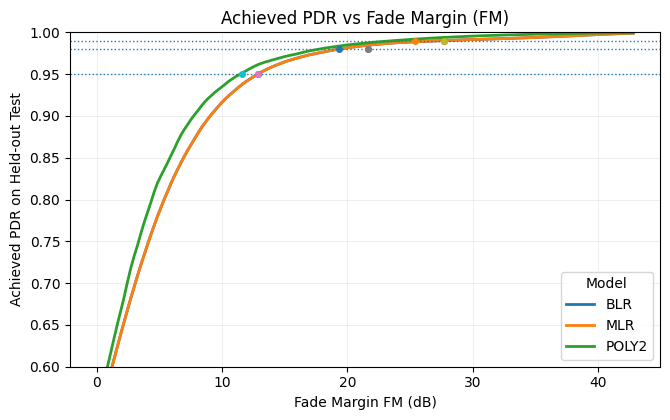

In [6]:
def pdr_curve(eps_test, fm_min=0.0, fm_max=None, num=160):
    if fm_max is None:
        fm_max = max(HEURISTIC_FM_DB, np.percentile(eps_test, 99.9))
    grid = np.linspace(fm_min, fm_max, num=num)
    # achieved PDR = 1 - outage = empirical CDF of residuals at FM
    pdr = np.array([np.mean(eps_test <= m) for m in grid], float)
    return grid, pdr

# Shared x-range across all models so curves are comparable
eps_all = [v for v in test_residuals.values()]
shared_fm_max = max(HEURISTIC_FM_DB, *[np.percentile(eps, 99.9) for eps in eps_all])

curves = {}
for fam, eps_test in test_residuals.items():
    fm_grid, pdr_grid = pdr_curve(eps_test, fm_min=0.0, fm_max=shared_fm_max, num=160)
    curves[fam] = {"fm_grid": fm_grid, "pdr_grid": pdr_grid}

plt.figure(figsize=(6.8, 4.3))

# Plot PDR curves
for fam in ["BLR", "MLR", "POLY2"]:
    if fam in curves:
        plt.plot(curves[fam]["fm_grid"], curves[fam]["pdr_grid"], linewidth=2, label=fam)

# Horizontal lines at targets
for p in P_GRID:
    plt.axhline(1.0 - p, linestyle=":", linewidth=1.0)

# Place markers at each model’s calibrated FM(p)
for fam in ["BLR", "MLR", "POLY2"]:
    sub = fm_table[fm_table["model"] == fam]
    for p in P_GRID:
        fm_p = sub.loc[sub["p"] == p, "fm_sel"]
        if not fm_p.empty:
            plt.plot([fm_p.iloc[0]], [1.0 - p], marker="o", markersize=4)

plt.title("Achieved PDR vs Fade Margin (FM)")
plt.xlabel("Fade Margin FM (dB)")
plt.ylabel("Achieved PDR on Held-out Test")
plt.ylim(0.6, 1.0)
plt.grid(True, which="both", linewidth=0.5, alpha=0.3)
plt.legend(title="Model", loc="lower right")
os.makedirs("Reports/FM", exist_ok=True)
plt.tight_layout()
# plt.savefig("Reports/FM/pdr_vs_fm_overlay.png", dpi=600)
plt.show()

#### Save CSV Summaries + Paper Snippet

In [7]:
os.makedirs("Reports/FM", exist_ok=True)

fm_csv = "Reports/FM/fm_calibration_summary.csv"
validation_csv = "Reports/FM/fm_validation_summary.csv"
fm_table.to_csv(fm_csv, index=False)
validation_df.to_csv(validation_csv, index=False)

print("Saved:", fm_csv)
print("Saved:", validation_csv)

def paper_snippet(model_name, p=0.01):
    sub = fm_table[(fm_table["model"] == model_name) & (fm_table["p"] == p)].iloc[0]
    val = validation_df[(validation_df["model"] == model_name) & (validation_df["p_target"] == p)].iloc[0]
    fm = sub["fm_sel"]; lo = sub["fm_sel_lo"]; hi = sub["fm_sel_hi"]; est = sub["selected"]
    ach_p = val["achieved_outage"]; ach_pdr = val["achieved_PDR"]
    return (
        f"FM calibration for {model_name}: For p={p:.2%}, we obtain FM{int((1-p)*100)} = {fm:.2f} dB "
        f"[95% BC: {lo:.2f}, {hi:.2f}] using {est}. On held-out test, achieved outage "
        f"is {ach_p:.2%} (PDR={ach_pdr:.2%})."
    )

for fam in ["BLR", "MLR", "POLY2"]:
    if fam in fm_table["model"].unique():
        print(paper_snippet(fam, p=0.01))

Saved: Reports/FM/fm_calibration_summary.csv
Saved: Reports/FM/fm_validation_summary.csv
FM calibration for BLR: For p=1.00%, we obtain FM99 = 27.74 dB [95% BC: 27.62, 27.62] using empirical. On held-out test, achieved outage is 0.98% (PDR=99.02%).
FM calibration for MLR: For p=1.00%, we obtain FM99 = 27.74 dB [95% BC: 27.62, 27.62] using empirical. On held-out test, achieved outage is 0.98% (PDR=99.02%).
FM calibration for POLY2: For p=1.00%, we obtain FM99 = 25.39 dB [95% BC: 23.93, 23.93] using gmm-tail. On held-out test, achieved outage is 0.81% (PDR=99.19%).
